In [1]:
%matplotlib inline

In [195]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from cv2 import VideoWriter, VideoWriter_fourcc
import pandas as pd
import torch
from scipy import signal, ndimage, spatial
from scipy.signal import correlate
from scipy.interpolate import CubicSpline
from scipy.ndimage import gaussian_filter
import math 
from signal_alignment import phase_align, chisqr_align
from scipy.interpolate import interp1d
import scipy.stats as stats
from scipy.stats import spearmanr

### Function Definitions 

In [3]:
def cleaning_wave_df(DF):
    # dropping columns with no value
    #DF = DF.dropna(axis =1) 
    # dropping wave id column
    DF = DF.drop(columns = 2, axis =1)
    # name the first sensor columns 
    cols_0={0: "Time", 1: "FrameID", 3: "SensorID", 4: "Sensor_1Status", 5: "X_Nose", 6: "Y_Nose", 7:"Z_Nose"}
    DF = DF.rename(columns=cols_0, errors="raise")
    DF = DF.drop(columns = [8,9,10, 11], axis =1)
    
    DF = DF.drop(columns = [12,13,14,15,16,17,18,19,20], axis =1)
    cols_1={21: "SensorID", 22: "Sensor_2Status", 23: "X_LLeft", 24: "Y_LLeft", 25:"Z_LLeft"}
    DF = DF.rename(columns=cols_1, errors="raise")
    
    DF = DF.drop(columns = [26,27,28,29], axis =1)
    cols_2={30: "SensorID", 31: "Sensor_3Status", 32: "X_LR", 33: "Y_LR", 34:"Z_LR"}
    DF = DF.rename(columns=cols_2, errors="raise")
    
    DF = DF.drop(columns = [35,36,37,38], axis =1)
    cols_3={39: "SensorID", 40: "Sensor_4Status", 41: "X_UL", 42: "Y_UL", 43:"Z_UL"}
    DF = DF.rename(columns=cols_3, errors="raise")
    
    DF = DF.drop(columns = [44,45,46,47], axis =1)
    cols_4={48: "SensorID", 49: "Sensor_5Status", 50: "X_LL", 51: "Y_LL", 52:"Z_LL"}
    DF = DF.rename(columns=cols_4, errors="raise")
    
    DF = DF.drop(columns = [53,54,55,56], axis =1)
    cols_5={57: "SensorID", 58: "Sensor_6Status", 59: "X_JR", 60: "Y_JR", 61:"Z_JR"}
    DF = DF.rename(columns=cols_5, errors="raise")
    
    DF = DF.drop(columns = [62,63,64,65], axis =1)
    cols_6={66: "SensorID", 67: "Senson_7Status", 68: "X_JL", 69: "Y_JL", 70:"Z_JL"}
    DF = DF.rename(columns=cols_6, errors="raise")
    DF = DF.drop(columns = [71,72,73,74], axis =1)
    return DF

# cleaning video data 

def cleaning_video_df(DF):
    
    # choose the needed columns and convert the values to mm
    DF = DF[["BAG_Frame_number",'Time_Stamp (s)','Video_Frame_number',
             'landmark_48', 'landmark_48.1', 'landmark_48.2', 'landmark_54',
            'landmark_54.1', 'landmark_54.2', 'landmark_51', 'landmark_51.1',
            'landmark_51.2', 'landmark_57', 'landmark_57.1', 'landmark_57.2']]
  
    
    DF = DF.rename(columns={'Time_Stamp (s)': 'Time', "landmark_48": "X_LR", "landmark_48.1": "Y_LR",
                           "landmark_48.2": "Z_LR", "landmark_54": "X_LLeft",
                           "landmark_54.1": "Y_LLeft", "landmark_54.2": "Z_LLeft",
                           "landmark_51": "X_UL", "landmark_51.1": "Y_UL",
                           "landmark_51.2": "Z_UL", "landmark_57": "X_LL", "landmark_57.1": "Y_LL",
                           "landmark_57.2": "Z_LL"})
    
    DF = DF.astype({ "X_LR": np.double, "Y_LR": np.double,"Z_LR": np.double, "X_LLeft": np.double,
                            "Y_LLeft": np.double, "Z_LLeft": np.double, "X_UL": np.double,  "Y_UL": np.double,
                            "Z_UL": np.double,  "X_LL": np.double,  "Y_LL": np.double, "Z_LL": np.double})
    
    # conver the values from m to mm
    DF[["X_LR", "Y_LR","Z_LR", "X_LLeft", "Y_LLeft", "Z_LLeft", "X_UL",  "Y_UL","Z_UL",  "X_LL", 
       "Y_LL", "Z_LL"]] =  DF[["X_LR", "Y_LR","Z_LR", "X_LLeft", "Y_LLeft", "Z_LLeft", "X_UL",  "Y_UL","Z_UL",  "X_LL", 
       "Y_LL", "Z_LL"]]*1000
    return DF

def area_of_triangle(A,B,C):

    """
    computes the area of a triangle given by 3 points in 2d or 3d

    A, B and C must be numpy arrays

    it works with vectors A=[a1,a2,a3], B=[b1,b2,b3], c=[c1,c2,c3] or matrices

    A=[[a11,a12,a13],...[a1n,a2n,b3n]], B=[[b11,b12,b13],...[b1n,b2n,b3n]], C=[[c11,c12,c13],...[c1n,c2n,c3n]]

    """

    As = A.shape
    Bs = B.shape
    Cs = C.shape
   
    if len(As) == 1 :

        #we got vectors

        if (As[0]>3) or (Bs[0]>3) or (Cs[0]>3):

            raise Exception('coordinates can only be 2d or 3d')

            return None

    else:

        #check at least one of the dimensions is two or three
        if (As[0]==2) or (As[0]==3) or (As[1]==2) or (As[1]==3):

            #one of the dimensions of A is 2 or 3, now check that all the vectors have the same size
            if (As!=Bs) or (As!=Cs):

                raise Exception('vectors must be the same size')
                return None

            else:
                #move forward
                pass

        else:

            raise Exception('coordinates can only be 2d or 3d')

            return None

    #at this point we know that one of the dimensions has 2 or 3 elements we move forward assuming that
    #the user provided the vectors with the correct size
    #move all vectors to the same origin

    AB = B-A
    AC = C-A  

    if len(As) == 1 :

        #if only one vector the simply compute the norm of the cross product
        area = (1/2)*np.linalg.norm(np.cross(AB,AC))

    else:

        #if only multiple vectors compute the norm along the axis one
        area = (1/2)*np.linalg.norm(np.cross(AB,AC), axis = 1)   

    return area

def lipDist(DF):
    
    # Assumes columns are named in a particular way 
    
    DF['Horiz_Lip_Motion'] = DF.apply(lambda row: math.sqrt((row.X_LLeft - row.X_LR)**2 + (row.Y_LLeft - row.Y_LR)**2
                                                                  + (row.Z_LLeft - row.Z_LR)**2), axis = 1) 
    DF['Vert_Lip_Motion'] = DF.apply(lambda row: math.sqrt((row.X_UL - row.X_LL)**2 + (row.Y_UL - row.Y_LL)**2 +
                                                                 (row.Z_UL - row.Z_LL)**2), axis = 1)
    return DF

In [4]:
# Signal Processing

# sampling frequency set to 100 HZ
fsample = 100

def sig_shift(signal, amount):
    length = len(signal)    
    shifted = np.zeros(length+amount - 1)
    shifted[:amount-1] = 0
    shifted[amount-1:] = signal[:]
    return shifted

def sig_norm(signal):
    signal_mean = np.mean(signal)
    signal_normalised = signal - signal_mean
    return signal_normalised

# Butterworth filter 8-order, 15hz cutoff
fc = 15
w = fc / (fsample/2)
b , a = signal.butter(8, w, btype ='lowpass')

In [33]:
def rom(list_of_arrays):

    
    reps_max_values = np.array([np.max(array) for array in list_of_arrays])
    reps_min_values = np.array([np.min(array) for array in list_of_arrays])
    
    
    ROM = reps_max_values - reps_min_values
    
    return ROM

### Reading, Cleaning, and Preprocessing DATA

In [5]:
Tasks = ['REST', 'OPEN', 'SPREAD', 'OOEE', 'PA', 'BBP', 'TNG_PROTRUSION', 'TNG_LAT', 'TNG_NOSE']
Conditions = ['FAST', 'SLOW', 'DISOR', 'HOLD']

TASK_DFS_VIDEO_LIST = list()
TASK_DFS_WAVE_LIST = list()

In [6]:
# choose a task to do the analysis on,for example open, spread, pa, bbp, etc
Task = Tasks[2]

In [7]:
#####   WAVE DATA   ######

# read the wave data files of the chosen task into dfs and store them all in a list 
path_w = r'C:\Users\jafarid\Documents\Code\ValidationStudy\wave_data'
ext_w=('.tsv')
Files_w = os.listdir(path_w)           
Files_w = [i for i in Files_w if i.endswith(ext_w)]


for i in range(0, len(Files_w)):
    # choose which task to focus on 
    if Task in Files_w[i]:
        #print(Files_w[i])
        df = pd.read_csv(path_w+ "\\" + Files_w[i], delimiter='\t', skiprows=1,header=None)
        df = cleaning_wave_df(df)
        # depending on the file we are reading the indexing below needs to change 
        #if Files_w[i][20:-4] == 'EN_HOLD_1' or Files_w[i][20:-4] == 'EN_HOLD':
        df['FileName'] = Files_w[i][24:-4]
        
        #else: 
        #    df['FileName'] = Files_w[i][20:-4]
        df['FileName'] = Files_w[i][18:-4]
        df['PatientID'] = Files_w[i][:2]
        df['DataDATE'] = Files_w[i][5:13]
        df['Task'] = Task
        for condition in Conditions:
            if condition in Files_w[i]:
                df['Condition'] = condition

            if 'Condition' not in df.columns:
                df['Condition'] = 'NORM'
                
   
        # preprocessing, using the cubic interpolation to fill in the missing data 
        df = df.interpolate(method ='cubic', limit_direction ='forward') 
        df = lipDist(df)

        left_area = area_of_triangle(df[["X_LLeft", "Y_LLeft", "Z_LLeft"]].values, df[["X_UL",  "Y_UL","Z_UL"]].values, 
                                       df[["X_LL", "Y_LL", "Z_LL"]].values)
        df['Area_Left'] = np.array(left_area)
        right_area = area_of_triangle(df[["X_LR", "Y_LR","Z_LR"]].values, df[["X_UL",  "Y_UL","Z_UL"]].values, 
                                        df[[ "X_LL", "Y_LL", "Z_LL"]].values)
        df['Area_Right'] =  np.array(right_area)        
        df["Area_Ratio"] = df.apply(lambda row: row.Area_Left/row.Area_Right, axis = 1)
        
        # Displacements
        df['Vert_Lip_Motion_F1']= signal.filtfilt(b, a, df['Vert_Lip_Motion'])
        df['Horiz_Lip_Motion_F1'] = signal.filtfilt(b, a, df['Horiz_Lip_Motion'])
        # velocity 
        df["Speed"] = np.gradient(df['Horiz_Lip_Motion'], df["Time"])
        
        # Gaussian filter
        #df['Vert_Lip_Motion_F1']= gaussian_filter(df['Vert_Lip_Motion'], sigma=3)
        #df['Horiz_Lip_Motion_F1']= gaussian_filter(df['Horiz_Lip_Motion'], sigma=3)
        #df["Speed_F1"] = gaussian_filter(np.gradient(df['Vert_Lip_Motion'], df["Time"]), 3)
        
        # Butterworth filter 8-order, 15hz cutoff
        #df['Vert_Lip_Motion_F2']= signal.filtfilt(b, a, df['Vert_Lip_Motion'])
        #df['Horiz_Lip_Motion_F2']= signal.filtfilt(b, a, df['Horiz_Lip_Motion'])
        #df["Speed_F2"] = signal.filtfilt(b, a, np.gradient(df['Horiz_Lip_Motion'], df["Time"]))
        df['Area_Right']= signal.filtfilt(b, a, df['Area_Right'])
        df['Area_Left']= signal.filtfilt(b, a, df['Area_Left'])
        
        TASK_DFS_WAVE_LIST.append(df)
        
 
        print(Files_w[i][:2], Files_w[i][18:-4])

    


DJ SPREAD_HOLD
DJ SPREAD_NORM
MK SPREAD_HOLD
MK SPREAD_NORM
RM SPREAD_HOLD
RM SPREAD_NORM


In [8]:
if 0:
#%matplotlib qt
    plt.plot(TASK_DFS_WAVE_LIST[3]['Horiz_Lip_Motion'],'b')
    plt.plot(TASK_DFS_WAVE_LIST[3]['Horiz_Lip_Motion_F1'],'g')
    plt.plot(TASK_DFS_WAVE_LIST[3]['Horiz_Lip_Motion_F2'],'r')
#a1 = signal.filtfilt(b, a, df['Horiz_Lip_Motion'])
#plt.plot(TASK_DFS_WAVE_LIST[3]['Speed_F1'],'b')
#plt.plot(TASK_DFS_WAVE_LIST[3]['Vert_Lip_Motion_F1'],'g')
#plt.plot(TASK_DFS_WAVE_LIST[3]['Vert_Lip_Motion_F2'],'r')

In [9]:
#####   VIDEO DATA   ######

# read the wave data files of the chosen task into dfs and store them all in a list 
path_v = r'C:\Users\jafarid\Documents\Code\ValidationStudy\video_data_processed'
ext_v=('_Landmarks3D.csv')
Files_v = os.listdir(path_v)           
Files_v = [i for i in Files_v if i.endswith(ext_v)]

for i in range(0, len(Files_v)):
    # choose which task to focus on 
    if Task in Files_v[i]:
        df = pd.read_csv(path_v+ "\\" + Files_v[i])
        df =  df.drop([0]) 
        df = cleaning_video_df(df)
        # depending on the file we are reading the indexing below needs to change 
        df['FileName'] = Files_v[i][12:-16]
        df['PatientID'] = Files_v[i][:2]
        df['DataDATE'] = Files_v[i][5:13]
        df['Task'] = Task
        for condition in Conditions:
            if condition in Files_v[i]:
                df['Condition'] = condition

            if 'Condition' not in df.columns:
                df['Condition'] = 'NORMAL'
                

        # preprocessing, using the cubic interpolation to fill in the missing data 
        df = df.interpolate(method ='cubic', limit_direction ='forward') 
        df = lipDist(df)

        left_area = area_of_triangle(df[["X_LLeft", "Y_LLeft", "Z_LLeft"]].values, df[["X_UL",  "Y_UL","Z_UL"]].values, 
                                       df[["X_LL", "Y_LL", "Z_LL"]].values)
        df['Area_Left'] = np.array(left_area)
        right_area = area_of_triangle(df[["X_LR", "Y_LR","Z_LR"]].values, df[["X_UL",  "Y_UL","Z_UL"]].values, 
                                        df[[ "X_LL", "Y_LL", "Z_LL"]].values)
        df['Area_Right'] =  np.array(right_area)        
        df["Area_Ratio"] = df.apply(lambda row: row.Area_Left/row.Area_Right, axis = 1)
        
        
        
        df['Vert_Lip_Motion_F1']= signal.filtfilt(b, a, df['Vert_Lip_Motion'])
        df['Horiz_Lip_Motion_F1'] = signal.filtfilt(b, a, df['Horiz_Lip_Motion'])
        df["Speed"] = np.gradient(df['Horiz_Lip_Motion'], df["Time"])
        
        #df['Vert_Lip_Motion_F1']= gaussian_filter(df['Vert_Lip_Motion'], sigma=3)
        #df['Horiz_Lip_Motion_F1']= gaussian_filter(df['Horiz_Lip_Motion'], sigma=3)
        #df["Speed_F1"] = gaussian_filter(np.gradient(df['Horiz_Lip_Motion_F1'], df["Time"]), 3)
        
        # Butterworth filter 8-order, 15hz cutoff
        #df['Vert_Lip_Motion_F2']= signal.filtfilt(b, a, df['Vert_Lip_Motion'])
        #df['Horiz_Lip_Motion_F2']= signal.filtfilt(b, a, df['Horiz_Lip_Motion'])
        df['Area_Right']= signal.filtfilt(b, a, df['Area_Right'])
        df['Area_Left']= signal.filtfilt(b, a, df['Area_Left'])
        #df["Speed_F2"] = signal.filtfilt(b, a, np.gradient(df['Horiz_Lip_Motion'], df["Time"]))
        
        TASK_DFS_VIDEO_LIST.append(df)
        print(Files_v[i][12:-16])

    


SPREAD_HOLD
SPREAD_NORM
SPREAD_HOLD
SPREAD_NORM
SPREAD_HOLD
SPREAD_NORM


In [10]:
if 0:
    v = np.linalg.norm(TASK_DFS_VIDEO_LIST[0][["X_LLeft", "Y_LLeft", "Z_LLeft"]].values, axis=1)
    u = np.linalg.norm(TASK_DFS_VIDEO_LIST[0][["X_LL", "Y_LL", "Z_LL"]].values, axis=1)
    x = np.linalg.norm(TASK_DFS_VIDEO_LIST[0][["X_UL",  "Y_UL","Z_UL"]].values, axis=1)
    z = TASK_DFS_VIDEO_LIST[0][['Horiz_Lip_Motion_F2']].values
    #v
    plt.figure()
    # lower lip
    plt.plot(u,'r')
    plt.figure()
    # upper lip  
    plt.plot(x,'b')
    # upper lip  
    plt.plot(v,'g')
    #plt.plot(v,'g')
    plt.figure()
    plt.plot(z,'b')
    #plt.plot(TASK_DFS_VIDEO_LIST[0]['Area_Left'],'r')
    #plt.plot(TASK_DFS_VIDEO_LIST[0]['Area_Right'],'b')
    #plt.plot(TASK_DFS_VIDEO_LIST[3]['Speed_F1'],'b')

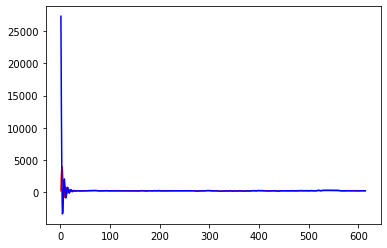

In [11]:
plt.plot(TASK_DFS_VIDEO_LIST[0]['Area_Left'],'r')
plt.plot(TASK_DFS_VIDEO_LIST[0]['Area_Right'],'b')

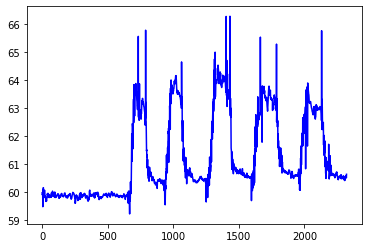

In [12]:
plt.plot(TASK_DFS_WAVE_LIST[3]['Horiz_Lip_Motion'],'b')
#plt.plot(TASK_DFS_VIDEO_LIST[0]['Horiz_Lip_Motion'],'r')

In [13]:

TASK_DFS_WAVE_100HZ_LIST = list()


In [14]:
# RESAMPLING TO 100Hz for the wave data

for DF_WAVE in TASK_DFS_WAVE_LIST:
    WAVE_100HZ = pd.DataFrame()
    tmax = len(DF_WAVE.Time) - 1
    tmax_value = DF_WAVE.Time[tmax]
    tmin_value = DF_WAVE.Time[0]
    
    nsample = fsample*(tmax_value - tmin_value)
    nsample = math.ceil(nsample)
    perfect_time = np.linspace(tmin_value, tmax_value, num= nsample, endpoint=True)
    WAVE_100HZ['Time'] = perfect_time
    f_motion = interp1d(DF_WAVE.Time, DF_WAVE['Vert_Lip_Motion_F1'], kind = 'linear')
    WAVE_100HZ['Vert_Lip_Motion'] = f_motion(perfect_time)
    f_motion2 = interp1d(DF_WAVE.Time, DF_WAVE['Horiz_Lip_Motion_F1'], kind = 'linear')
    WAVE_100HZ['Horiz_Lip_Motion'] = f_motion2(perfect_time)
    f_speed = interp1d(DF_WAVE.Time, DF_WAVE['Speed'], kind = 'linear')
    WAVE_100HZ['Speed'] = f_speed(perfect_time)
    WAVE_100HZ['FileName'] = DF_WAVE['FileName'][1]
    WAVE_100HZ['PatientID'] = DF_WAVE['PatientID'][1]
    TASK_DFS_WAVE_100HZ_LIST.append(WAVE_100HZ)
    #print(len(DF_WAVE['Horiz_Lip_Motion_F1']))
    #print(len(WAVE_100HZ['Horiz_Lip_Motion']))
    #print()

In [15]:
TASK_DFS_VIDEO_100HZ_LIST = list()

In [16]:
# Upsampling to 100Hz for the video data
for DF_VIDEO in TASK_DFS_VIDEO_LIST:
    WAVE_100HZ = pd.DataFrame()
    tmax = len(DF_VIDEO.Time) - 1
    tmax_value = DF_VIDEO.Time[tmax]
    tmin_value = DF_VIDEO.Time[1]
    nsample = fsample*(tmax_value - tmin_value)
    nsample = math.ceil(nsample)
    perfect_time = np.linspace(tmin_value, tmax_value, num= nsample, endpoint=True)
    WAVE_100HZ['Time'] = perfect_time
    f_motion = interp1d(DF_VIDEO.Time, DF_VIDEO['Vert_Lip_Motion_F1'], kind = 'linear')
    WAVE_100HZ['Vert_Lip_Motion'] = f_motion(perfect_time)
    f_motion2 = interp1d(DF_VIDEO.Time, DF_VIDEO['Horiz_Lip_Motion_F1'], kind = 'linear')
    WAVE_100HZ['Horiz_Lip_Motion'] = f_motion2(perfect_time)
    f_speed = interp1d(DF_VIDEO.Time, DF_VIDEO['Speed'], kind = 'linear')
    WAVE_100HZ['Speed'] = f_speed(perfect_time)
    WAVE_100HZ['FileName'] = DF_VIDEO['FileName'][1]
    WAVE_100HZ['PatientID'] = DF_VIDEO['PatientID'][1]
    TASK_DFS_VIDEO_100HZ_LIST.append(WAVE_100HZ)
    #print(len(DF_VIDEO['Horiz_Lip_Motion_F1']))
    #print(len(WAVE_100HZ['Horiz_Lip_Motion']))
    #print()

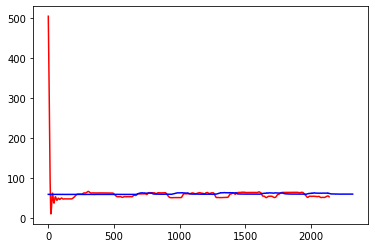

In [17]:
plt.plot(TASK_DFS_VIDEO_100HZ_LIST[0]['Horiz_Lip_Motion'],'r')
plt.plot(TASK_DFS_WAVE_100HZ_LIST[3]['Horiz_Lip_Motion'],'b')

In [18]:
print(len(TASK_DFS_VIDEO_100HZ_LIST))
print(len(TASK_DFS_WAVE_100HZ_LIST))

6
6


In [19]:
sn_pc = list()
sh_pc = list()

sn_rms_list = list()
sh_rms_list = list()

Final_DFS_LIST = list()

SPREAD_HOLD
Wave index:0
Video index:0
The phase shift is:174.24
The corrolation r and p-value between the signals are: r0.9667535760306141, p0.0

SPREAD_NORM
Wave index:1
Video index:1
The phase shift is:149.13
The corrolation r and p-value between the signals are: r0.9514445226770757, p0.0

SPREAD_HOLD
Wave index:2
Video index:2
The phase shift is:134.12
The corrolation r and p-value between the signals are: r0.816663086059577, p0.0

SPREAD_NORM
Wave index:3
Video index:3
The phase shift is:163.32
The corrolation r and p-value between the signals are: r0.866717336784808, p0.0

SPREAD_HOLD
Wave index:4
Video index:4
The phase shift is:164.75
The corrolation r and p-value between the signals are: r0.9193106651005393, p0.0

SPREAD_NORM
Wave index:5
Video index:5
The phase shift is:232.20000000000002
The corrolation r and p-value between the signals are: r0.8913303172107117, p0.0



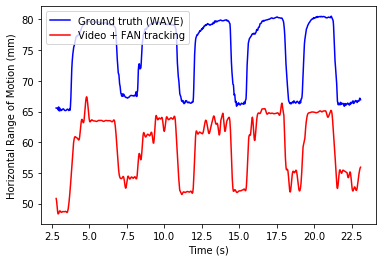

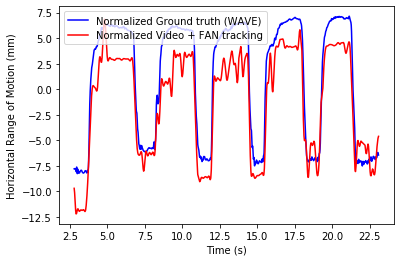

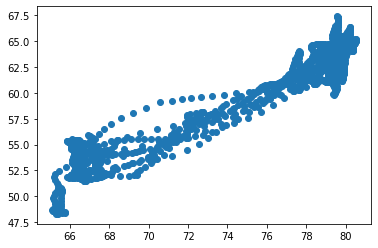

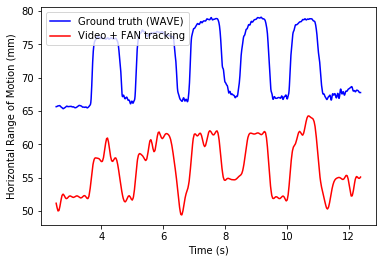

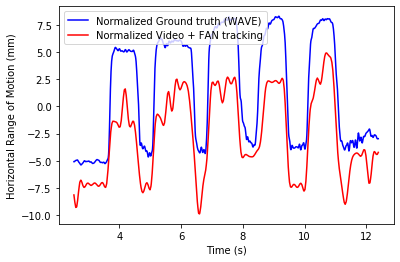

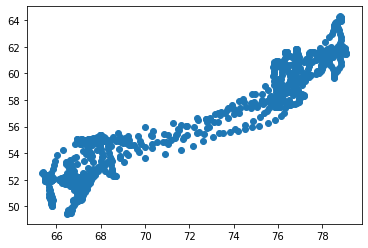

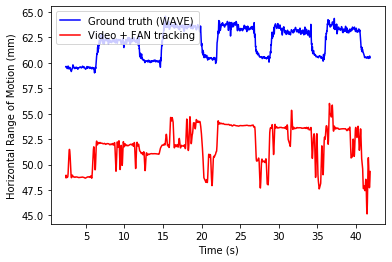

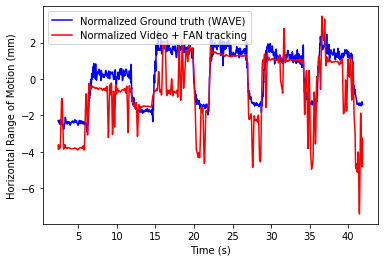

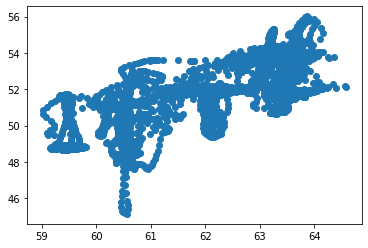

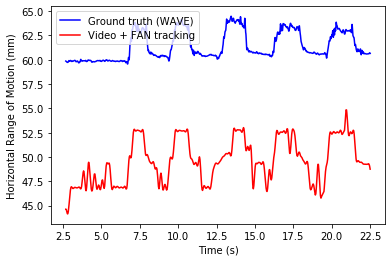

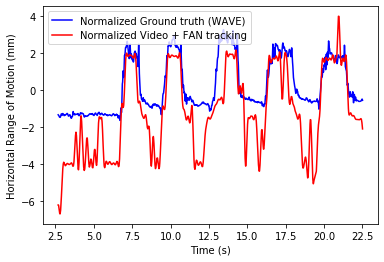

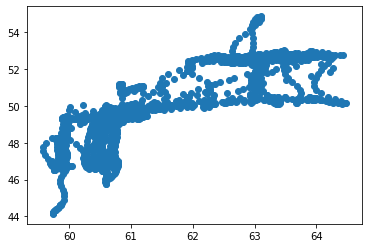

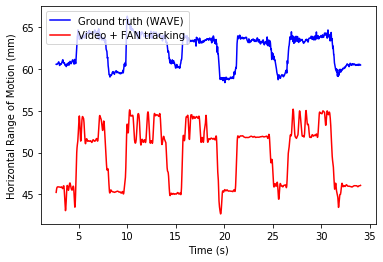

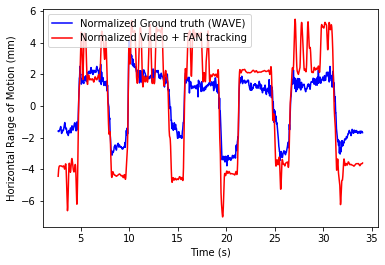

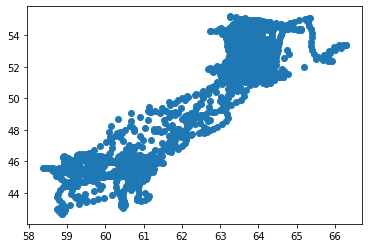

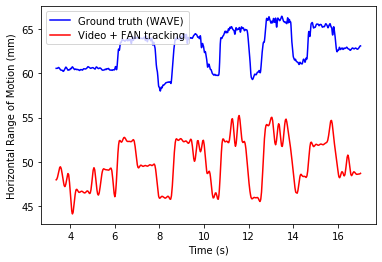

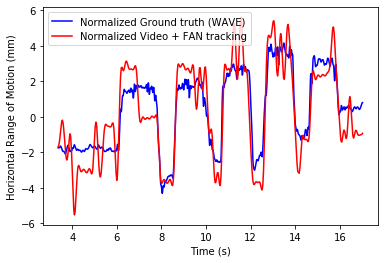

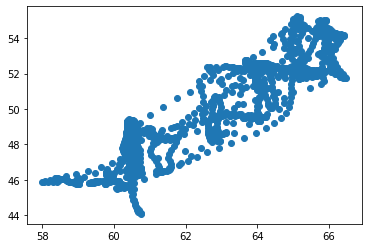

In [20]:
for i in range(len(TASK_DFS_WAVE_100HZ_LIST)):
    for j in range(len(TASK_DFS_VIDEO_100HZ_LIST)):
        if TASK_DFS_WAVE_100HZ_LIST[i]['PatientID'][1]== TASK_DFS_VIDEO_100HZ_LIST[j]['PatientID'][1]:
            if TASK_DFS_WAVE_100HZ_LIST[i]['FileName'][1]== TASK_DFS_VIDEO_100HZ_LIST[j]['FileName'][1]:
                print(TASK_DFS_WAVE_100HZ_LIST[i]['FileName'][1])
                print('Wave index:{}'.format(i))
                print('Video index:{}'.format(j))
                result = pd.DataFrame() 

                video_n = sig_norm(TASK_DFS_VIDEO_100HZ_LIST[j]['Horiz_Lip_Motion'])
                wave_n = sig_norm(TASK_DFS_WAVE_100HZ_LIST[i]['Horiz_Lip_Motion'])
                time = TASK_DFS_WAVE_100HZ_LIST[i]['Time'].values
                time_w = TASK_DFS_WAVE_100HZ_LIST[i]['Time'].values
                time_v = TASK_DFS_WAVE_100HZ_LIST[i]['Time'].values
                
                if len(video_n)<=len(wave_n):
                    upper_bound = len(video_n) 
                else: 
                    upper_bound = len(wave_n) 

               

                s = phase_align(wave_n, video_n, [5,upper_bound])
                print('The phase shift is:{}'.format(s))

                sp = math.ceil(s)


                video_shifted = sig_shift(TASK_DFS_VIDEO_100HZ_LIST[j]['Horiz_Lip_Motion'],sp)
                video_n_s = sig_shift( video_n,sp)
                video_speed_shifted = sig_shift(TASK_DFS_VIDEO_100HZ_LIST[j]['Speed'],sp)
                
                wave_shifted = TASK_DFS_WAVE_100HZ_LIST[i]['Horiz_Lip_Motion'].values
                wave_speed_shifted = TASK_DFS_WAVE_100HZ_LIST[i]['Speed'].values
                
                upper_bound_shifted = upper_bound + sp -1
                
                if len(wave_shifted)< upper_bound_shifted:
                    upper_bound_shifted = len(wave_shifted)
             
                name = TASK_DFS_WAVE_100HZ_LIST[i]['PatientID'][1] + '_' + TASK_DFS_WAVE_100HZ_LIST[i]['FileName'][1]
                
                range_l = sp+100
                range_u = upper_bound_shifted-10
                
                result['Time_WAVE'] = time_w[range_l:range_u]
                result['Time_VIDEO'] = time_v[range_l:range_u]
                result['HorizDisp_WAVE'] = wave_shifted[range_l:range_u]
                result['HorizDisp_VIDEO'] = video_shifted[range_l:range_u]
                
                result['Speed_WAVE'] = wave_speed_shifted[range_l:range_u]
                result['Speed_VIDEO'] = video_speed_shifted[range_l:range_u]
                
                result['FileName'] = TASK_DFS_WAVE_100HZ_LIST[i]['FileName'][1]
                result['PatientID'] = TASK_DFS_WAVE_100HZ_LIST[i]['PatientID'][1]
                cvs = 'final_paper_data/SPREAD_'+ name +'.csv'
                result.to_csv(cvs)
                Final_DFS_LIST.append(result)
                plt.figure()
                
                plt.plot(time[range_l:range_u], wave_shifted[range_l:range_u],'b', label='Ground truth (WAVE)')
                plt.plot(time[range_l:range_u],video_shifted[range_l:range_u],'r', label='Video + FAN tracking')
                plt.legend(loc="upper left")
                plt.xlabel('Time (s)')
                plt.ylabel('Horizontal Range of Motion (mm)')
                
                plt.savefig('{}'.format(name))
                
                
                plt.figure()
                
                plt.plot(time[range_l:range_u],wave_n[range_l:range_u],'b', label='Normalized Ground truth (WAVE)')
                plt.plot(time[range_l:range_u],video_n_s[range_l:range_u],'r', label='Normalized Video + FAN tracking')
                plt.legend(loc="upper left")
                plt.xlabel('Time (s)')
                plt.ylabel('Horizontal Range of Motion (mm)')
                plt.savefig('{}'.format(name+'Normalized'))


             
                plt.figure()
                plt.scatter(wave_shifted[range_l:range_u], video_shifted[range_l:range_u]) 
                
                
                r, p = stats.pearsonr(video_n_s[range_l:range_u], wave_n[range_l:range_u])
                print('The corrolation r and p-value between the signals are: r{}, p{}'.format(r,p))
                print()
                rms = np.sqrt(np.mean((wave_n[range_l:range_u]-video_n_s[range_l:range_u])**2))
                
                if TASK_DFS_WAVE_100HZ_LIST[i]['FileName'][1] == "SPREAD_HOLD":
                    sh_pc.append(r)
                    sh_rms_list.append(rms)
                elif TASK_DFS_WAVE_100HZ_LIST[i]['FileName'][1] == "SPREAD_NORM":
                    sn_pc.append(r)
                    sn_rms_list.append(rms)
                
                #plt.figure()
                #plt.plot(TASK_DFS_WAVE_100HZ_LIST[i]['Horiz_Lip_Motion'],'b')
                #plt.plot(TASK_DFS_VIDEO_100HZ_LIST[j]['Horiz_Lip_Motion'],'r')
               
                

                #plt.figure()
                #plt.plot(TASK_DFS_WAVE_100HZ_LIST[i]['Horiz_Lip_Motion'],'b')
                #plt.plot(video_shifted,'r')
             

                #plt.figure()
                #plt.scatter(TASK_DFS_WAVE_100HZ_LIST[i]['Horiz_Lip_Motion'][sp:signal_bound], 
                #            video_shifted[sp:signal_bound])

    

# START HERE

In [208]:
# DO NOT RUN MORE THAN ONCE
parsed_df = pd.DataFrame(columns=['PatientID','FileName','REP','ROM_VIDEO','ROM_WAVE', 'SpdAvg_WAVE', 
                                  'SpdAvg_VIDEO','Disp_WAVE', 'Disp_VIDEO','Time_WAVE', 'Time_VIDEO',
                                  'Speed_WAVE', 'Speed_VIDEO'])


reps = ['R1', 'R2', 'R3', 'R4', 'R5']
len(Final_DFS_LIST)

6

In [254]:
reps = ['R1', 'R2', 'R3', 'R4', 'R5']
#reps = ['R1', 'R2', 'R3', 'R4']

In [309]:
def apnd_adj (d, v, t, i):
    d[i] = d[i].append(d[i+1])
    v[i] = v[i].append(v[i+1])
    t[i] = t[i].append(t[i+1])
    d.pop(i+1)
    v.pop(i+1)
    t.pop(i+1)
    return d, v, t

In [283]:
# df at hand 
DF = Final_DFS_LIST[5]

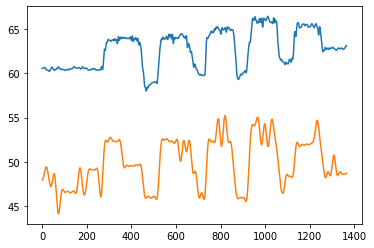

In [284]:
plt.plot(DF['HorizDisp_WAVE'])
plt.plot(DF['HorizDisp_VIDEO'])

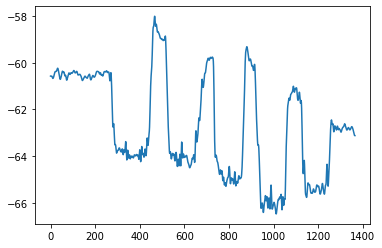

In [285]:
plt.plot(-DF['HorizDisp_WAVE'])
#plt.plot(DF['HorizDisp_VIDEO'])

In [299]:
peaks, _ = signal.find_peaks(-DF['HorizDisp_WAVE'], height= -63, distance= 50)

print(peaks)


[  32  105  174  251  467  666  725  880 1089 1260 1319]


In [300]:
reps_w = np.array_split(DF['HorizDisp_WAVE'], peaks)
reps_w_v = np.array_split(DF['Speed_WAVE'], peaks)
reps_w_t = np.array_split(DF['Time_WAVE'], peaks)

reps_v = np.array_split(DF['HorizDisp_VIDEO'], peaks)
reps_v_v = np.array_split(DF['Speed_VIDEO'], peaks)
reps_v_t = np.array_split(DF['Time_VIDEO'], peaks)

if 0:
    reps_v.pop(0)
    reps_v_v.pop(0)
    reps_v_t.pop(0)
    reps_v.pop(-1)
    reps_v_v.pop(-1)
    reps_v_t.pop(-1)
    reps_w.pop(0)
    reps_w_v.pop(0)
    reps_w_t.pop(0)
    reps_w.pop(-1)
    reps_w_v.pop(-1)
    reps_w_t.pop(-1)

print(len(reps_w))

12


In [306]:
if 0: 
    reps_w.pop(2)
    reps_w_v.pop(2)
    reps_w_t.pop(2)
    print(len(reps_w))
    
    reps_v.pop(2)
    reps_v_v.pop(2)
    reps_v_t.pop(2)
    print(len(reps_v), len(reps_w))
    

if 0: 
    reps_w.pop(-1)
    reps_w_v.pop(-1)
    reps_w_t.pop(-1)
    reps_v.pop(-1)
    reps_v_v.pop(-1)
    reps_v_t.pop(-1)
    print(len(reps_v), len(reps_w))
    
if 1: 
    reps_w.pop(0)
    reps_w_v.pop(0)
    reps_w_t.pop(0)
    reps_v.pop(0)
    reps_v_v.pop(0)
    reps_v_t.pop(0)
    print(len(reps_v),len(reps_w))

6 6


5 5


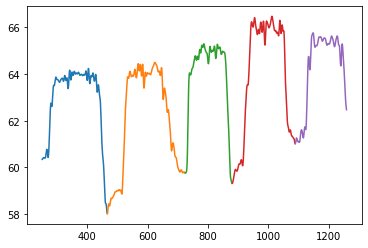

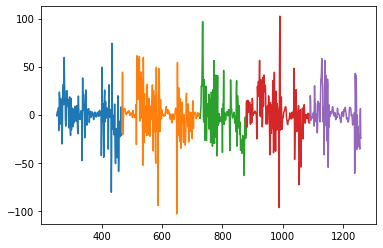

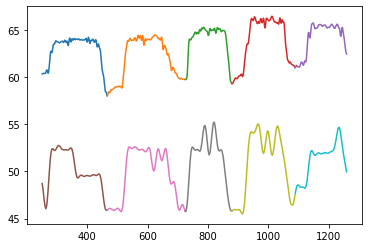

In [311]:
plt.figure()
for i in reps_w:
    plt.plot(i)

plt.figure()
for i in reps_w_v:
    plt.plot(i)
    
plt.figure()
for i in reps_w:
    plt.plot(i)
for i in reps_v:
    plt.plot(i)
print(len(reps_v),len(reps_w))

In [310]:
### CAUTION
if 1:
    reps_w, reps_w_v, reps_w_t = apnd_adj(reps_w, reps_w_v, reps_w_t, 1)
    reps_v, reps_v_v, reps_v_t = apnd_adj(reps_v, reps_v_v, reps_v_t, 1)

In [312]:
# ROM and AVG speed analysis 
rom_w = rom(reps_w)
rom_v = rom(reps_v)
ave_s_w = np.array([np.mean(abs(rep_v)) for rep_v in reps_w_v])
ave_s_v = np.array([np.mean(abs(rep_v)) for rep_v in reps_v_v])
print(rom_w)
print(rom_v)
print(ave_s_w)
print(ave_s_v)

[6.19043561 6.48967704 5.95087804 7.16179359 4.75856529]
[6.8967915  6.86853393 9.48584144 9.5413327  7.06671377]
[11.95464245 11.75727236 16.31288079 13.69048278 11.58708051]
[ 7.7397464   8.32994543 15.13523021 16.28826017  7.19758975]


In [313]:
current_df = pd.DataFrame()

current_df['REP'] = reps
current_df['PatientID'] =  DF['PatientID'][1]
current_df['FileName'] = DF['FileName'][1]  
current_df['ROM_WAVE'] = rom_w
current_df['ROM_VIDEO'] = rom_v
current_df['SpdAvg_WAVE'] = ave_s_w
current_df['SpdAvg_VIDEO'] = ave_s_v
current_df['Disp_WAVE'] = reps_w  
current_df['Time_WAVE'] = reps_w_t  
current_df['Time_VIDEO'] = reps_v_t
current_df['Disp_VIDEO'] = reps_v
current_df['Speed_WAVE'] = reps_w_v 
current_df['Speed_VIDEO'] = reps_v_v

current_df.head()

,REP,PatientID,FileName,ROM_WAVE,ROM_VIDEO,SpdAvg_WAVE,SpdAvg_VIDEO,Disp_WAVE,Time_WAVE,Time_VIDEO,Disp_VIDEO,Speed_WAVE,Speed_VIDEO
0,R1,RM,SPREAD_NORM,6.190436,6.896791,11.954642,7.739746,251 60.344455 252 60.352335 253 60.37...,251 5.876650 252 5.886653 253 5.89665...,251 5.876650 252 5.886653 253 5.89665...,251 48.713397 252 48.510261 253 48.30...,251 -0.461892 252 -1.477990 253 2.74...,251 -16.085324 252 -27.057672 253 -37.69...
1,R2,RM,SPREAD_NORM,6.489677,6.868534,11.757272,8.329945,467 58.008940 468 58.076581 469 58.21...,467 8.037371 468 8.047374 469 8.05...,467 8.037371 468 8.047374 469 8.05...,467 45.899650 468 45.933671 469 45.96...,467 -18.618416 468 16.732428 469 44.10...,467 -1.080167 468 -0.917047 469 -0.75392...
2,R3,RM,SPREAD_NORM,5.950878,9.485841,16.312881,15.135230,725 59.758245 726 59.761576 727 59.77...,725 10.618233 726 10.628236 727 10.63...,725 10.618233 726 10.628236 727 10.63...,725 45.779303 726 45.760298 727 45.74...,725 -2.986319 726 -4.027192 727 -0.02...,725 -0.069198 726 -0.127846 727 -0.18649...
3,R4,RM,SPREAD_NORM,7.161794,9.541333,13.690483,16.288260,880 59.314610 881 59.317376 882 59...,880 12.168750 881 12.178753 882 12...,880 12.168750 881 12.178753 882 12...,880 45.811654 881 45.824333 882 45...,880 14.163781 881 -4.662498 882 -12...,880 -0.584750 881 -0.930718 882 -0...
4,R5,RM,SPREAD_NORM,4.758565,7.066714,11.587081,7.197590,1089 61.008386 1090 61.032013 1091 61...,1089 14.259448 1090 14.269451 1091 14...,1089 14.259448 1090 14.269451 1091 14...,1089 47.608902 1090 47.804422 1091 47...,1089 -8.739626 1090 -3.898479 1091 19...,1089 24.483601 1090 12.578880 1091 0...


In [314]:
print(len(reps_w_t ))
print(len(reps_v_t ))

5
5


In [315]:
parsed_df = parsed_df.append(current_df,ignore_index=True)

print(len(parsed_df))

29


In [316]:
# MAKE SURE TO CHANGE THIS!!!!!!!!!

cvs = 'SPREAD_PARSED_ANALYSIS_2.csv'
parsed_df.to_csv(cvs)

# DONE!

In [317]:
for i in range(len(parsed_df)):
    rep_df = pd.DataFrame()
    
    rep_df['Disp_VIDEO'] = parsed_df['Disp_VIDEO'][i]
    rep_df['Speed_VIDEO'] = parsed_df['Speed_VIDEO'][i]
    rep_df['Time_VIDEO'] = parsed_df['Time_VIDEO'][i]
    
    
    rep_df['PatientID'] =  parsed_df['PatientID'][i]
    rep_df['FileName'] = parsed_df['FileName'][i]  

    rep_df['ROM_VIDEO'] = parsed_df['ROM_VIDEO'] [i]

    rep_df['SpdAvg_VIDEO'] = parsed_df ['ROM_VIDEO'][i]
    name = parsed_df['PatientID'][i] + '_' + parsed_df['FileName'][i] + '_VIDEO_' +parsed_df['REP'][i] 

    cvs = 'Parsed_Data2/SPREAD_'+ name +'.csv'
    current_df.to_csv(cvs)

In [318]:
for i in range(len(parsed_df)):
    rep_df = pd.DataFrame()
    
    rep_df['Disp_WAVE'] = parsed_df['Disp_WAVE'][i]
    rep_df['Speed_WAVE'] = parsed_df['Speed_WAVE'][i]
    rep_df['Time_WAVE'] = parsed_df['Time_WAVE'][i]
    
    rep_df['PatientID'] =  parsed_df['PatientID'][i]
    rep_df['FileName'] = parsed_df['FileName'][i]  

    rep_df['ROM_WAVE'] = parsed_df['ROM_WAVE'] [i]

    rep_df['SpdAvg_WAVE'] = parsed_df ['ROM_WAVE'][i]
    name = parsed_df['PatientID'][i] + '_' + parsed_df['FileName'][i] + '_WAVE_' +parsed_df['REP'][i] 

    cvs = 'Parsed_Data2/SPREAD_'+ name +'.csv'
    current_df.to_csv(cvs)

In [319]:
deniz = parsed_df.loc[lambda DF: parsed_df['PatientID'] == 'DJ']
mk = parsed_df.loc[lambda DF: parsed_df['PatientID'] == 'MK']
rm = parsed_df.loc[lambda DF: parsed_df['PatientID'] == 'RM']

In [326]:
print(stats.spearmanr(deniz['ROM_WAVE'].values, deniz['ROM_VIDEO'].values))
print(stats.spearmanr(deniz['SpdAvg_WAVE'].values, deniz['SpdAvg_VIDEO'].values))
print()
#print(stats.pearsonr(mk['ROM_WAVE'].values, mk['ROM_Video'].values))
print(stats.spearmanr(mk['ROM_WAVE'].values, mk['ROM_VIDEO'].values))
print(stats.spearmanr(mk['SpdAvg_WAVE'].values, mk['SpdAvg_VIDEO'].values))
print()
#print(stats.pearsonr(rm['ROM_WAVE'].values, rm['ROM_Video'].values))
print(stats.spearmanr(rm['ROM_WAVE'].values, rm['ROM_VIDEO'].values))
print(stats.spearmanr(rm['SpdAvg_WAVE'].values, rm['SpdAvg_VIDEO'].values))
#print(stats.pearsonr(sig_norm(rm['ROM_WAVE'].values), sig_norm(rm['ROM_VIDEO'].values)))
print()

print(stats.spearmanr(parsed_df['ROM_WAVE'].values, parsed_df['ROM_VIDEO'].values))
print(stats.spearmanr(parsed_df['SpdAvg_WAVE'].values, parsed_df['SpdAvg_VIDEO'].values))
print()

SpearmanrResult(correlation=0.6363636363636362, pvalue=0.04791172612997547)
SpearmanrResult(correlation=0.32121212121212117, pvalue=0.3654683104386702)

SpearmanrResult(correlation=-0.3, pvalue=0.4328453267094823)
SpearmanrResult(correlation=-0.11666666666666665, pvalue=0.7650079429261462)

SpearmanrResult(correlation=0.04242424242424241, pvalue=0.9073638178128159)
SpearmanrResult(correlation=0.5272727272727272, pvalue=0.11730806555020223)

SpearmanrResult(correlation=0.7413793103448275, pvalue=4.20395467545858e-06)
SpearmanrResult(correlation=0.5714285714285713, pvalue=0.0012040339221990153)



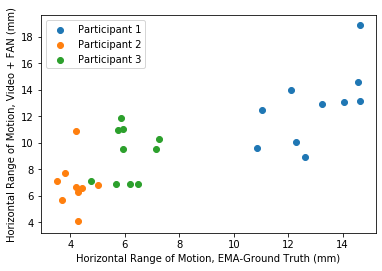

In [330]:
plt.figure()
plt.scatter(deniz['ROM_WAVE'].values, deniz['ROM_VIDEO'].values, label='Participant 1' )


plt.scatter(mk['ROM_WAVE'].values, mk['ROM_VIDEO'].values, label='Participant 2')

plt.scatter(rm['ROM_WAVE'].values, rm['ROM_VIDEO'].values, label='Participant 3')



plt.legend(loc="upper left")
plt.xlabel('Horizontal Range of Motion, EMA-Ground Truth (mm)')
plt.ylabel('Horizontal Range of Motion, Video + FAN (mm)')
plt.savefig('{}'.format('SPREAD_REP_CORR'))

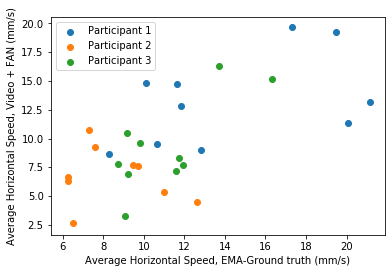

In [334]:
plt.figure()
plt.scatter(deniz['SpdAvg_WAVE'].values, deniz['SpdAvg_VIDEO'].values, label='Participant 1')


plt.scatter(mk['SpdAvg_WAVE'].values, mk['SpdAvg_VIDEO'].values, label='Participant 2')

plt.scatter(rm['SpdAvg_WAVE'].values, rm['SpdAvg_VIDEO'].values, label='Participant 3')

plt.legend(loc="upper left")
plt.xlabel('Average Horizontal Speed, EMA-Ground truth (mm/s)')
plt.ylabel('Average Horizontal Speed, Video + FAN (mm/s)')
plt.savefig('{}'.format('SPREAD_REP_CORR_V'))

SPREAD_HOLD_R1
SPREAD_HOLD_R2
SPREAD_HOLD_R3
SPREAD_HOLD_R4
SPREAD_HOLD_R5
SPREAD_NORM_R1
SPREAD_NORM_R2
SPREAD_NORM_R3
SPREAD_NORM_R4
SPREAD_NORM_R5


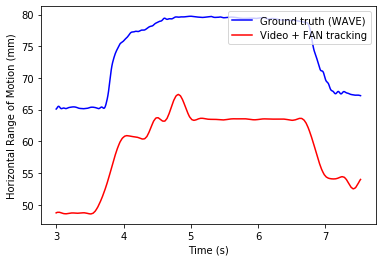

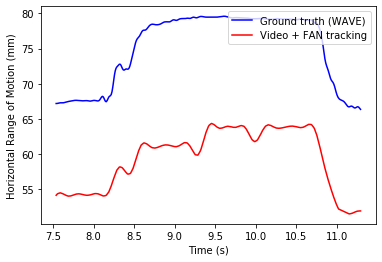

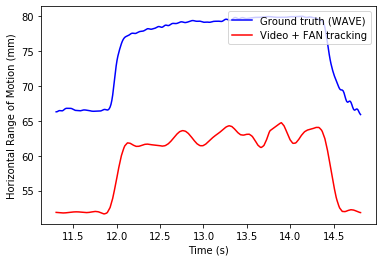

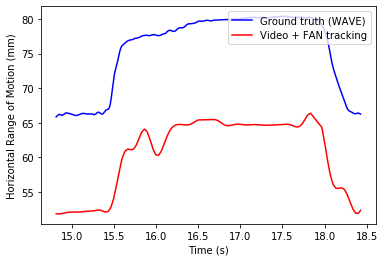

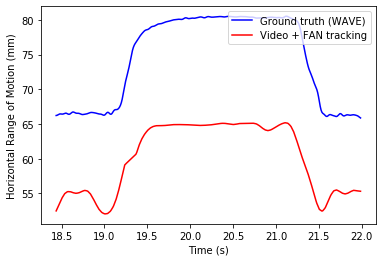

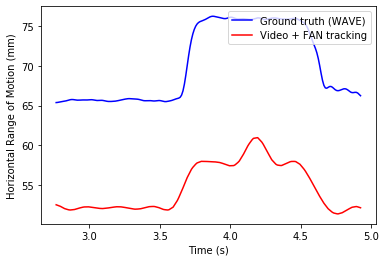

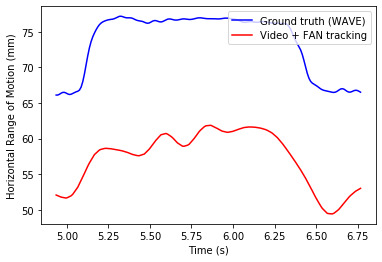

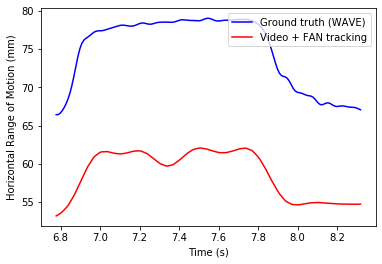

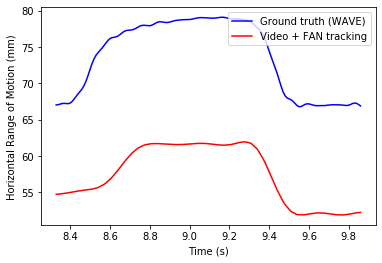

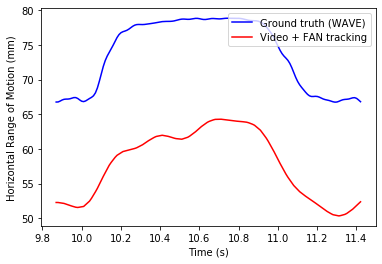

In [333]:
for i in range(len(deniz)):

    print(deniz['FileName'][i] + '_' + deniz['REP'][i] )
    plt.figure()
    
    plt.plot(deniz['Time_WAVE'][i].values, deniz['Disp_WAVE'][i].values, 'b', label='Ground truth (WAVE)')
    plt.plot( deniz['Time_VIDEO'][i].values,deniz['Disp_VIDEO'][i].values, 'r', label='Video + FAN tracking')
    
    plt.legend(loc="upper right")
    plt.xlabel('Time (s)')
    plt.ylabel('Horizontal Range of Motion (mm)')
    plt.savefig('{}'.format('MS_REP_' +deniz['FileName'][i] + '_' + deniz['REP'][i]))

In [ ]:
plt.figure()
plt.scatter(deniz['ROM_WAVE'].values, deniz['ROM_VIDEO'].values )

plt.figure()
plt.scatter(mk['ROM_WAVE'].values, mk['ROM_VIDEO'].values)

plt.figure()
plt.scatter(rm['ROM_WAVE'].values, rm['ROM_VIDEO'].values)

SPREAD_HOLD_R1
SPREAD_HOLD_R2
SPREAD_HOLD_R3
SPREAD_HOLD_R4
SPREAD_HOLD_R5
SPREAD_NORM_R1
SPREAD_NORM_R2
SPREAD_NORM_R3
SPREAD_NORM_R4
SPREAD_NORM_R5


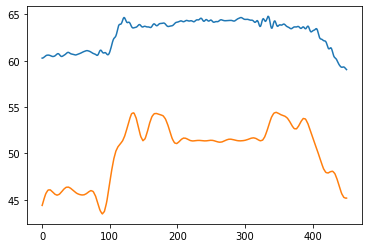

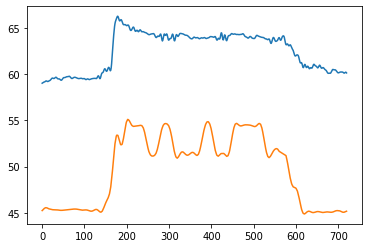

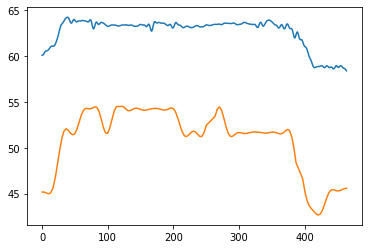

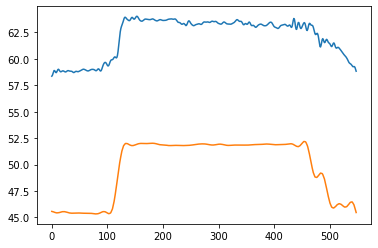

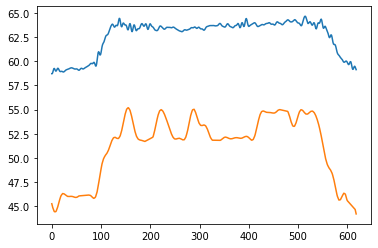

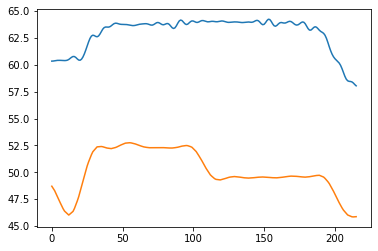

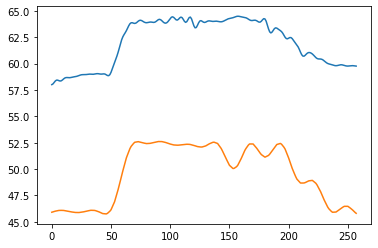

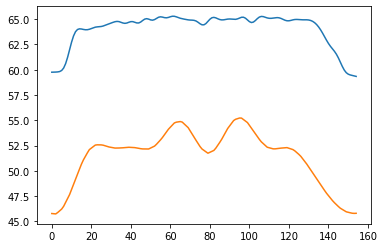

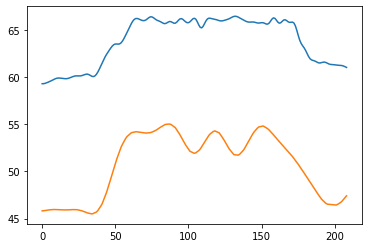

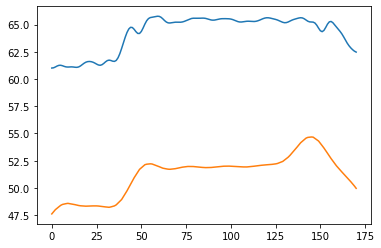

In [323]:
for i in range(len(rm)):
    i = i +19
    print(rm['FileName'][i] + '_' + rm['REP'][i] )
    plt.figure()
    
    plt.plot(rm['Disp_WAVE'][i].values)
    plt.plot(rm['Disp_VIDEO'][i].values)

In [ ]:
print(sn_pc)
print(sh_pc)

import statistics 
from statistics import mean 
from statistics import stdev 
print(mean(sn_pc))
print(mean(sh_pc))

print()
print(stdev(sn_pc))
print(stdev(sh_pc))


print(mean(sn_rms_list),stdev(sn_rms_list))
print(mean(sh_rms_list),stdev(sh_rms_list))


In [ ]:
sn_v_pc = list()
sh_v_pc = list()
sn_v_v = list()
sh_v_v = list()
sn_v_w = list()
sh_v_w = list()
sh_v_std_v = list()
sh_v_std_w = list()
sn_v_std_v = list()
sn_v_std_w = list()

In [ ]:
for i in range(len(Final_DFS_LIST)):
    plt.figure()
    plt.plot(Final_DFS_LIST[i]['Time'], Final_DFS_LIST[i]['Speed_WAVE'],
             'b',label='Ground truth (WAVE)')
    plt.plot(Final_DFS_LIST[i]['Time'],Final_DFS_LIST[i]['Speed_VIDEO'],
             'r', label='Video + FAN tracking')
    plt.legend(loc="upper left")
    plt.xlabel('Time (s)')
    plt.ylabel('Horizontal Range of Motion Velocity(mm/s)')
    plt.savefig('{}'.format(Final_DFS_LIST[i]['FileName'][1]+'Velocity'))
    r, p = stats.pearsonr(Final_DFS_LIST[i]['Speed_WAVE'], 
                          Final_DFS_LIST[i]['Speed_VIDEO'])
    
    
    ave_s_w = np.mean(abs(Final_DFS_LIST[i]['Speed_WAVE']))
    std_s_w = np.std(abs(Final_DFS_LIST[i]['Speed_WAVE']))
    ave_s_v = np.mean(abs(Final_DFS_LIST[i]['Speed_VIDEO']))
    std_s_v = np.std(abs(Final_DFS_LIST[i]['Speed_VIDEO']))
    if Final_DFS_LIST[i]['FileName'][1] == "SPREAD_HOLD":
        sh_v_pc.append(r)
       
        sh_v_v.append(ave_s_v)
        sh_v_w.append(ave_s_w)
        
        sh_v_std_v.append(std_s_v)
        sh_v_std_w.append(std_s_w)
      

    elif Final_DFS_LIST[i]['FileName'][1] == "SPREAD_NORM":
        sn_v_pc.append(r)
        sn_v_v.append(ave_s_v)
        sn_v_w.append(ave_s_w)
        
        sn_v_std_v.append(std_s_v)
        sn_v_std_w.append(std_s_w)
      

In [ ]:
print(sn_v_pc)
print(sh_v_pc)
print()
print(sn_v_w)
print(sn_v_v)
print()
print(sh_v_w)
print(sh_v_v)

print()
print(mean(sn_v_pc), stdev(sn_v_pc))
print(mean(sh_v_pc), stdev(sh_v_pc))

print()


In [ ]:
if 0:    
    video_n = sig_norm(TASK_DFS_VIDEO_100HZ_LIST[4]['Vert_Lip_Motion'])
    wave_n = sig_norm(TASK_DFS_WAVE_100HZ_LIST[6]['Vert_Lip_Motion'])

    upper_bound = len(video_n) - 10
    upper_bound2 = len(wave_n) - 10

    s = phase_align(wave_n[600:1100], video_n, [10,upper_bound])
    print('The phase shift is:{}'.format(s))

    sp = math.ceil(s) + 600


    video_shifted = sig_shift(TASK_DFS_VIDEO_100HZ_LIST[4]['Vert_Lip_Motion'],sp)

    if len(video_shifted) <= len(wave_n):
        signal_bound = upper_bound + sp
    else: 
        signal_bound = len(wave_n) - 10 

    print()
    plt.figure()

    plt.plot(TASK_DFS_WAVE_100HZ_LIST[6]['Vert_Lip_Motion'],'b')
    plt.plot(TASK_DFS_VIDEO_100HZ_LIST[4]['Vert_Lip_Motion'],'r')

    plt.figure()
    a = np.gradient(TASK_DFS_WAVE_100HZ_LIST[6]['Time'])
    plt.plot(a, 'b')
    b = np.gradient(TASK_DFS_VIDEO_100HZ_LIST[4]['Time'])
    plt.plot(b, 'r')

    plt.figure()
    plt.plot(TASK_DFS_WAVE_100HZ_LIST[6]['Vert_Lip_Motion'],'b')
    plt.plot(video_shifted,'r')

    plt.figure()
    plt.scatter(TASK_DFS_WAVE_100HZ_LIST[6]['Vert_Lip_Motion'][sp:signal_bound], 
                video_shifted[sp:signal_bound])
